<a href="https://colab.research.google.com/github/d-maniatakos/vaccine-sentiment-classifier/blob/master/vaccine_sentiment_classifier_using_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Modules Import**

In [55]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Download Glove & Create Dictionary**

In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-12-11 06:34:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-11 06:34:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-11 06:34:16--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [56]:
glove = {}

# read file line by line while creating glove dictionary
with open('glove.6B.100d.txt') as f:
    lines = f.readlines()
for line in lines:
  vector = []
  for dim in line.split(' ')[1:]:
    vector.append(float(dim))
  glove[line.split(' ')[0]] = np.array(vector)

## **Data Import**

In [57]:
# read datasets and ignore the first (index) column
train_data =  pd.read_csv('vaccine_train_set.csv').iloc[:, 1:]
validation_data = pd.read_csv('vaccine_validation_set.csv').iloc[:, 1:]    # <--- replace with test set path

train_data.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


## **Pre-processing & Vectorization**

In [58]:
# preprocess tweets texts before vectorization
def preprocess(text):
  text = text.lower()
  unwanted_chars = ['@', '#', '!', '(', ')', '*', ':', ',']

  for char in unwanted_chars:
    text = text.replace(char, '')
  lemmatizer = WordNetLemmatizer()

  lemmatized_text = ''
  for word in text.split():
    lemmatized_text += lemmatizer.lemmatize(word) + ' '
  return lemmatized_text


# vectorize a tweet using glove word embedding
def glove_vectorize(corpus, representation = 'average', vector_size = 100):
  vectors = []
  for document in corpus:
    glove_vectors = []
    document_size = 0
    for token in document.split():
      try:
        glove_vectors.append(torch.from_numpy(glove[token]))
        document_size += 1
      except:
        pass

    try:
      if representation == 'average':
        vectors.append(torch.stack(glove_vectors, dim=0).sum(dim=0).div(document_size))
      elif representation == 'sum':
        vectors.append(torch.stack(glove_vectors, dim=0).sum(dim=0))
    except:
      vectors.append(torch.zeros(vector_size))
    
  return torch.stack(vectors, dim=0).to(torch.float32)


# create a tf-idf or bow vectorizer (using the training set's tweets)
def create_vectorizer(train_corpus, method='tf-idf', max_features=1000, ngram_range=(1, 2)):
  if method == 'tf-idf':
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
  elif method == 'bow':
    vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
  return vectorizer.fit(train_corpus)

# vectorize a dataset
def vectorize(vectorizer, corpus):
  return torch.from_numpy(vectorizer.transform(corpus).toarray()).to(torch.float32)


train_data['tweet'] = train_data['tweet'].apply(preprocess)
validation_data['tweet'] = validation_data['tweet'].apply(preprocess)

train_corpus = train_data['tweet']
validation_corpus = validation_data['tweet']

## **First Model Creation & Training**

In [59]:
# use glove word embeddings
train_vector = glove_vectorize(train_corpus)
validation_vector = glove_vectorize(validation_corpus)

x_train = train_vector
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)

x_validation = validation_vector
y_validation = torch.tensor(validation_data['label'].values, dtype=torch.long)

# neural network class
class NeuralNetwork(nn.Module):
  def __init__(self, x_size, num_of_classes, hidden_size):
    super(NeuralNetwork, self).__init__()

    self.layer1 = nn.Linear(x_size, hidden_size)
    self.layer2 = nn.ReLU()
    self.layer3 = nn.Linear(hidden_size, num_of_classes)

  def forward(self, x):
    h1 = self.layer1(x)
    h2 = self.layer2(h1)
    out = self.layer3(h2)
    return out

# hyperparameters
input_size = 100
hidden_layer1_size = 50
output_size = 3
num_of_epochs = 30
batch_size = 100
learning_rate = 0.0005
loss_function = nn.CrossEntropyLoss()


model = NeuralNetwork(input_size, output_size, hidden_layer1_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

training_loss = []
validation_loss = []

# training
for epoch in range(num_of_epochs):
  batch_losses = []

  for index, (x, y) in enumerate(train_dataloader):
    y_pred = model(x)
    loss = loss_function(y_pred, y)
    batch_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = []


  y_pred_validation = model(x_validation)
  val_loss = loss_function(y_pred_validation, y_validation)

  
  print('Epoch: ' + str(epoch+1) + '/' + str(num_of_epochs) + ' Training Loss: ' + str(round(sum(batch_losses)/len(train_dataloader), 4)) + ' Validation Loss: ' + str(round(val_loss.item(), 4)))
  print('----------------------------------------------------------')
  training_loss.append((sum(batch_losses)/len(train_dataloader)))
  validation_loss.append(val_loss.item())

Epoch: 1/30 Training Loss: 0.9536 Validation Loss: 0.9006
----------------------------------------------------------
Epoch: 2/30 Training Loss: 0.8689 Validation Loss: 0.8528
----------------------------------------------------------
Epoch: 3/30 Training Loss: 0.8356 Validation Loss: 0.8314
----------------------------------------------------------
Epoch: 4/30 Training Loss: 0.8152 Validation Loss: 0.8172
----------------------------------------------------------
Epoch: 5/30 Training Loss: 0.802 Validation Loss: 0.8079
----------------------------------------------------------
Epoch: 6/30 Training Loss: 0.7905 Validation Loss: 0.8001
----------------------------------------------------------
Epoch: 7/30 Training Loss: 0.7821 Validation Loss: 0.793
----------------------------------------------------------
Epoch: 8/30 Training Loss: 0.7741 Validation Loss: 0.7899
----------------------------------------------------------
Epoch: 9/30 Training Loss: 0.7673 Validation Loss: 0.784
---------

## **First Model Evaluation**

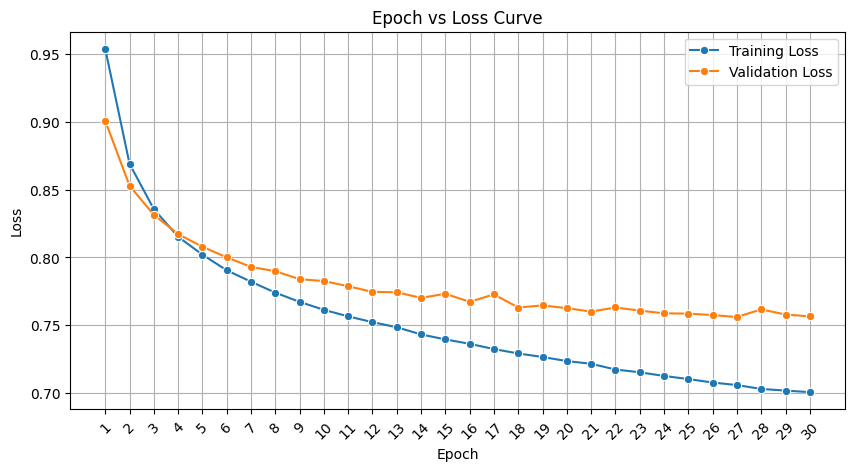

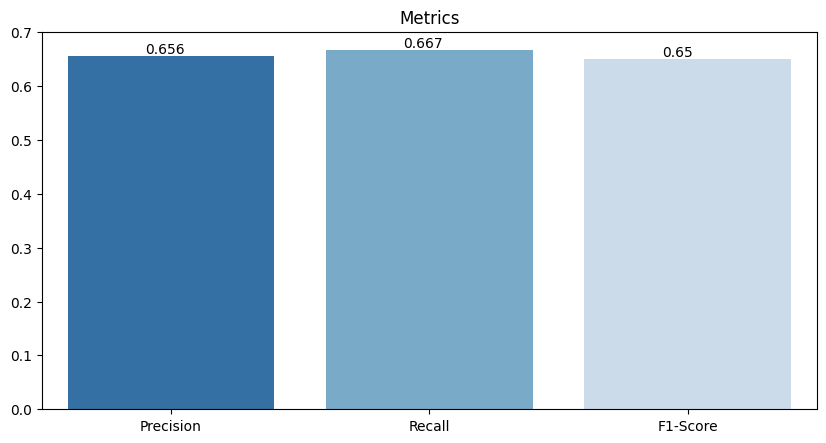

Precision: 0.6559423879677294
Recall: 0.6673970201577564
F1-Score: 0.6502805798503569


In [60]:
predictions = []
predictions_possibilities = []

for i in range(validation_vector.size()[0]):
  prediction = model.forward(validation_vector[i])
  predictions.append(torch.argmax(prediction).item())

  predictions_possibilities.append(prediction.tolist())

precision = precision_score(y_validation.tolist(), predictions, average='weighted')
recall = recall_score(y_validation.tolist(), predictions, average='weighted')
f1 = f1_score(y_validation.tolist(), predictions, average='weighted')

# plot the epoch vs loss curve
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Epoch vs Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
sns.lineplot(x=range(1, num_of_epochs+1), y=training_loss,  marker="o")
sns.lineplot(x=range(1, num_of_epochs+1), y=validation_loss,  marker="o")
plt.xticks(range(1, num_of_epochs+1))
plt.xticks(rotation=45)
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

# plot scores
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Metrics')
sns.barplot(x=['Precision', 'Recall', 'F1-Score'], y=[precision, recall, f1], palette='Blues_r')
for index, value in enumerate([precision, recall, f1]):
    plt.text(index-0.1, value+0.005,str(round(value,3)))
plt.show()

print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-Score: ' + str(f1))

## **Second Model Creation & Training**

In [63]:
# use tf-idf vectorization approach
tf_idf_vectorizer = create_vectorizer(train_data['tweet'])
train_vector = vectorize(tf_idf_vectorizer, train_corpus)
validation_vector = vectorize(tf_idf_vectorizer, validation_corpus)

x_train = train_vector
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)

x_validation = validation_vector
y_validation = torch.tensor(validation_data['label'].values, dtype=torch.long)

# neural network class
class NeuralNetwork(nn.Module):
  def __init__(self, x_size, num_of_classes, hidden_size):
    super(NeuralNetwork, self).__init__()
    self.layer1 = nn.Linear(x_size, hidden_size)
    self.layer2 = nn.ReLU()
    self.layer3 = nn.Linear(hidden_size, num_of_classes)

  def forward(self, x):
    h1 = self.layer1(x)
    h2 = self.layer2(h1)
    out = self.layer3(h2)
    return out

# hyperparameters
input_size = 1000
hidden_layer1_size = 50
output_size = 3
num_of_epochs = 30
batch_size = 100
learning_rate = 0.0005
loss_function = nn.CrossEntropyLoss()

model = NeuralNetwork(input_size, output_size, hidden_layer1_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

training_loss = []
validation_loss = []

# training
for epoch in range(num_of_epochs):
  batch_losses = []

  for index, (x, y) in enumerate(train_dataloader):
    y_pred = model(x)
    loss = loss_function(y_pred, y)
    batch_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = []


  y_pred_validation = model(x_validation)
  val_loss = loss_function(y_pred_validation, y_validation)

  
  print('Epoch: ' + str(epoch+1) + '/' + str(num_of_epochs) + ' Training Loss: ' + str(round(sum(batch_losses)/len(train_dataloader), 4)) + ' Validation Loss: ' + str(round(val_loss.item(), 4)))
  print('----------------------------------------------------------')
  training_loss.append((sum(batch_losses)/len(train_dataloader)))
  validation_loss.append(val_loss.item())

Epoch: 1/30 Training Loss: 0.9496 Validation Loss: 0.8267
----------------------------------------------------------
Epoch: 2/30 Training Loss: 0.7516 Validation Loss: 0.7245
----------------------------------------------------------
Epoch: 3/30 Training Loss: 0.6744 Validation Loss: 0.6895
----------------------------------------------------------
Epoch: 4/30 Training Loss: 0.6398 Validation Loss: 0.6774
----------------------------------------------------------
Epoch: 5/30 Training Loss: 0.6213 Validation Loss: 0.6704
----------------------------------------------------------
Epoch: 6/30 Training Loss: 0.6087 Validation Loss: 0.6678
----------------------------------------------------------
Epoch: 7/30 Training Loss: 0.6 Validation Loss: 0.6678
----------------------------------------------------------
Epoch: 8/30 Training Loss: 0.593 Validation Loss: 0.6675
----------------------------------------------------------
Epoch: 9/30 Training Loss: 0.5876 Validation Loss: 0.67
------------

## **Second Model Evaluation**

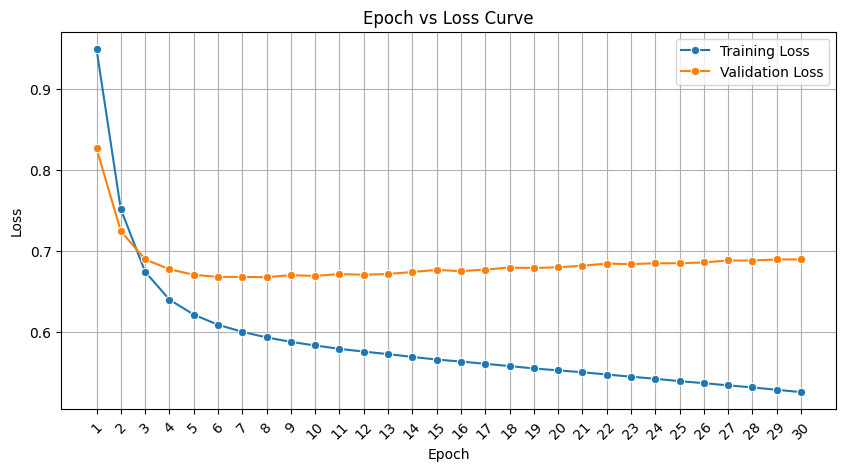

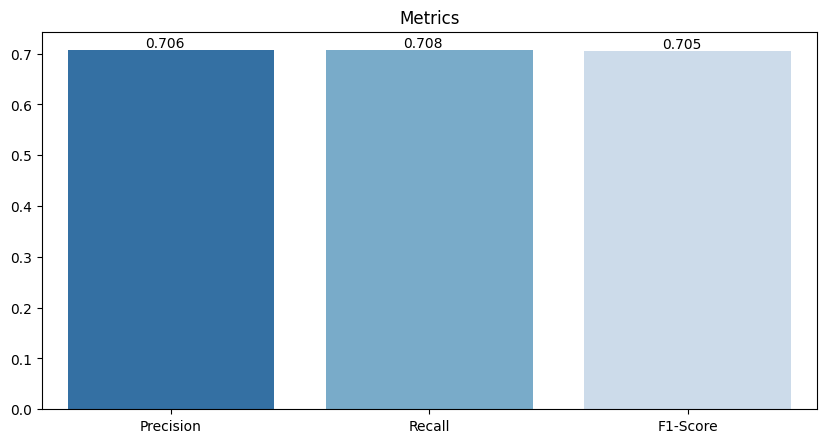

Precision: 0.7064969355265405
Recall: 0.7077125328659071
F1-Score: 0.7052427342445915


In [64]:
predictions = []
predictions_possibilities = []

for i in range(validation_vector.size()[0]):
  prediction = model.forward(validation_vector[i])
  predictions.append(torch.argmax(prediction).item())
  # print(prediction)

  predictions_possibilities.append(prediction.tolist())

precision = precision_score(y_validation.tolist(), predictions, average='weighted')
recall = recall_score(y_validation.tolist(), predictions, average='weighted')
f1 = f1_score(y_validation.tolist(), predictions, average='weighted')

# plot the epoch vs loss curve
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Epoch vs Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
sns.lineplot(x=range(1, num_of_epochs+1), y=training_loss,  marker="o")
sns.lineplot(x=range(1, num_of_epochs+1), y=validation_loss,  marker="o")
plt.xticks(range(1, num_of_epochs+1))
plt.xticks(rotation=45)
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

# plot scores
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Metrics')
sns.barplot(x=['Precision', 'Recall', 'F1-Score'], y=[precision, recall, f1], palette='Blues_r')
for index, value in enumerate([precision, recall, f1]):
    plt.text(index-0.1, value+0.005,str(round(value,3)))
plt.show()

print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-Score: ' + str(f1))